In [1]:
import pickle
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import colorcet
import seaborn as sns
from nltk import FreqDist
from sklearn.decomposition import KernelPCA
from pyemd import emd_samples
from pyemd import emd


In [2]:
with open("../data/concs_labeled_min.pickle", "rb") as f:
    concs_labeled = pickle.load(f)

In [3]:
concs = [conc[0] for conc in concs_labeled]
labels = [conc[1] for conc in concs_labeled]
years =  [int(conc[2]) for conc in concs_labeled]

(2010.0, 2021.0)

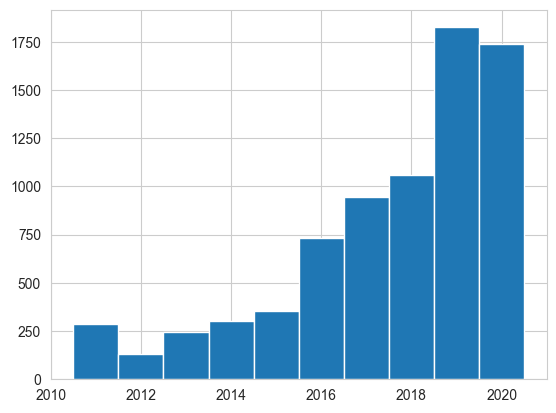

In [4]:
plt.hist(years, bins=[y+0.5 for y in range(2010, 2021)])
plt.xlim(2010,2021)

In [5]:
markers = ["o" if y<=2017 else "x" for y in years ]
len([el for el in markers if el=="x"])

4622

In [9]:
%%time
w2v = api.load('word2vec-google-news-300')
#w2v = KeyedVectors.load("../data/large_data/w2v_news300.model")


CPU times: user 23 s, sys: 1.14 s, total: 24.2 s
Wall time: 25 s


In [11]:
vocab_counts = FreqDist([w for conc in concs for w in conc]).most_common()
vocab = [tup[0] for tup in vocab_counts]

In [12]:
w2v.index_to_key
w2v_filtered = Word2Vec()

In [13]:
w2v.index_to_key

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 '####',
 'his',
 'an',
 'this',
 'or',
 'their',
 'who',
 'they',
 'but',
 '$',
 'had',
 'year',
 'were',
 'we',
 'more',
 '###',
 'up',
 'been',
 'you',
 'its',
 'one',
 'about',
 'would',
 'which',
 'out',
 'can',
 'It',
 'all',
 'also',
 'two',
 'after',
 'first',
 'He',
 'do',
 'time',
 'than',
 'when',
 'We',
 'over',
 'last',
 'new',
 'other',
 'her',
 'people',
 'into',
 'In',
 'our',
 'there',
 'A',
 'she',
 'could',
 'just',
 'years',
 'some',
 'U.S.',
 'three',
 'million',
 'them',
 'what',
 'But',
 'so',
 'no',
 'like',
 'if',
 'only',
 'percent',
 'get',
 'did',
 'him',
 'game',
 'back',
 'because',
 'now',
 '#.#',
 'before',
 'company',
 'any',
 'team',
 'against',
 'off',
 'This',
 'most',
 'made',
 'through',
 'make',
 'second',
 'state',
 'well',
 'day',
 'season',
 'says',
 'w

In [14]:
w2v_filtered = KeyedVectors(vector_size=300)
vocab_filtered = []
# Iterate over the original KeyedVectors object
for word in vocab:
    try:
        w2v_filtered[word] = w2v[word]
        vocab_filtered.append(word)
    except:
        pass

In [15]:
len(vocab_filtered)

7318

In [16]:
def return_vectors(word_list, keyed_vectors):
    vocab_set = set(keyed_vectors.index_to_key)

    """
    replace words by vectors, while omitting missing words
    """
    word_list_filtered = list(set(word_list) & vocab_set)
    return [keyed_vectors[word] for word in word_list_filtered]

In [17]:
%%time
concs_vectors =  [return_vectors(conc, w2v_filtered) for conc in concs]

CPU times: user 1.5 s, sys: 39.8 ms, total: 1.54 s
Wall time: 1.57 s


In [18]:
len(concs_vectors)

7617

(array([   7.,    9.,   27.,   37.,   96.,  185.,  360.,  676., 1050.,
        1520., 1728., 1334.,  585.]),
 array([ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5,
        18.5, 19.5, 20.5]),
 <BarContainer object of 13 artists>)

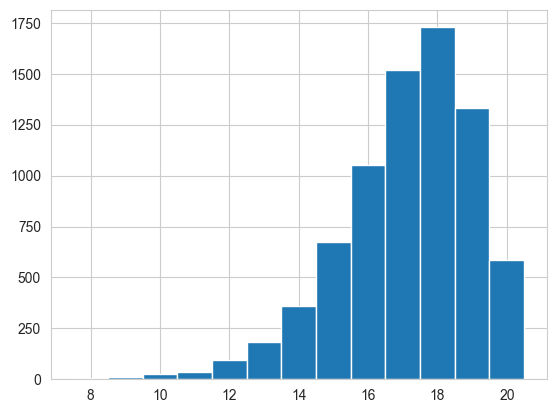

In [19]:
concs_vectors_lens = [len(conc) for conc in concs_vectors]
plt.hist(concs_vectors_lens, bins=[n+0.5 for n in range(7,21)])

In [21]:
vect = CountVectorizer(vocabulary=vocab_filtered, lowercase=False)
W_ = np.array([w2v_filtered[w] for w in vect.get_feature_names_out() if w in w2v_filtered.index_to_key])
D_ = euclidean_distances(W_).astype('float64')
D_ /= D_.max()  # just for comparison purposes
D_.shape

(7318, 7318)

In [22]:
concs_bows = vect.fit_transform([" ".join(conc) for conc in concs])
concs_bows = np.array([bow.toarray().ravel() for bow in concs_bows])
concs_bows.shape

(7617, 7318)

In [23]:
concs_bows_norm = [(bow / bow.sum()) for bow in concs_bows]

In [24]:
t1 = concs_bows_norm[10]
t2 = concs_bows_norm[20]

In [25]:
%%time
emd(t1, t2, D_)

CPU times: user 2.84 s, sys: 484 ms, total: 3.33 s
Wall time: 3.53 s


0.34954603791300076

In [26]:
# create a NumPy array of concatenated sentences
concs_array = np.array(concs, dtype=object)

# create an empty NumPy array of the correct size
distance_matrix = np.zeros((len(concs_array), len(concs_array)))

In [ ]:
# use a nested for loop to calculate the WMD distance between each pair of sentences
for i in range(len(concs_array)):
    if i in range(0, len(concs_array), 100):
        print(i)
    for j in range(len(concs_array)):
        distance_matrix[i, j] = w2v_filtered.wmdistance(concs_array[i], concs_array[j])

0
100


In [130]:
print("hello")

hello


In [ ]:
distance_matrix.shape

In [ ]:
with open("../data/large_data/distance_matrix_min.pickle", "wb") as f:
    pickle.dump(distance_matrix, f)

In [4]:
#with open("../data/large_data/distance_matrix.pickle", "rb") as f:
#    distance_matrix = pickle.load(f)